In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dask.dataframe as dd
import nltk

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recomm/tags.csv
/kaggle/input/recommend/movies.csv
/kaggle/input/recommend/ratings.csv


In [41]:
raw_movies = dd. read_csv("/kaggle/input/recommend/movies.csv")
raw_ratings = dd. read_csv("/kaggle/input/recommend/ratings.csv")
raw_tags = dd. read_csv("/kaggle/input/recomm/tags.csv")

In [42]:
print(raw_movies.shape[0].compute())
print(raw_ratings.shape[0].compute())
print(raw_tags.shape[0].compute())

87585
32000204
2000072


In [43]:
raw_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [44]:
raw_movies["year"] = raw_movies["title"].str.extract(r"\((\d{4})\)")[0]
raw_movies["title"] = raw_movies["title"].str.replace(r'\s\(\d{4}\)', '',regex=True)
raw_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [45]:
raw_movies = raw_movies.dropna(subset=["year"])

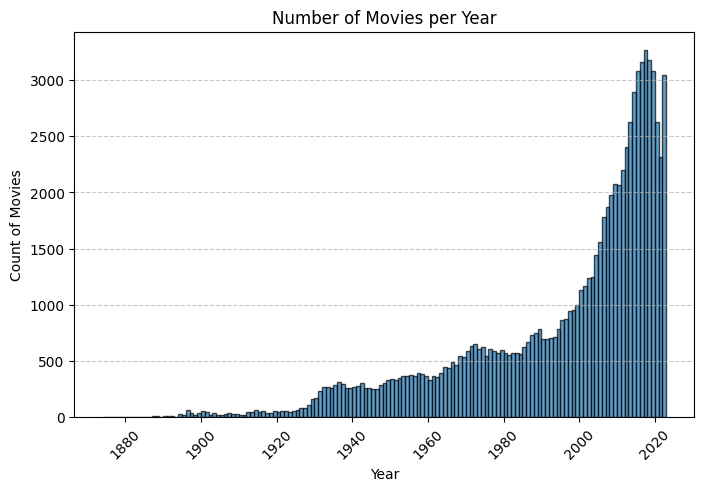

In [46]:
import matplotlib.pyplot as plt

# Drop NaN values from 'year' column
year_counts = raw_movies["year"].dropna().astype(int)

# Compute min and max year values
year_min = year_counts.min().compute()
year_max = year_counts.max().compute()

plt.figure(figsize=(8, 5))
plt.hist(year_counts.compute(), bins=range(year_min, year_max + 1), edgecolor="black", alpha=0.7)

plt.xlabel("Year")
plt.ylabel("Count of Movies")
plt.title("Number of Movies per Year")

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [47]:
raw_movies["year"] = raw_movies["year"].astype(int)

raw_movies = raw_movies[raw_movies["year"] >= 1990 ].compute()


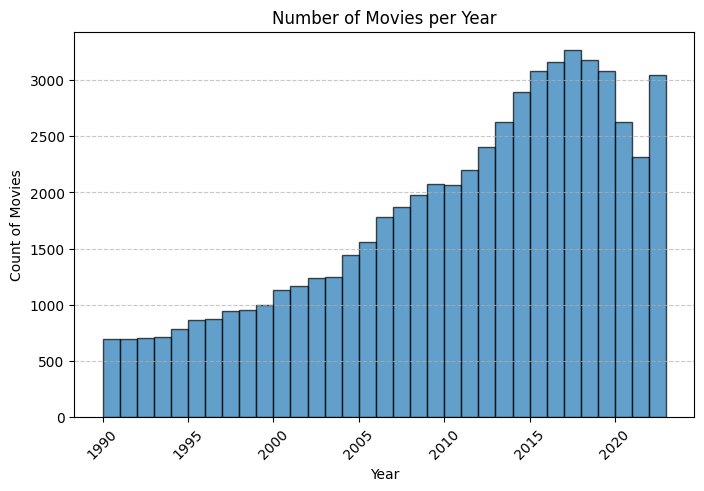

In [48]:
import matplotlib.pyplot as plt

# Drop NaN values from 'year' column
year_counts = raw_movies["year"].dropna().astype(int)

# Compute min and max year values
year_min = year_counts.min()
year_max = year_counts.max()

plt.figure(figsize=(8, 5))
plt.hist(year_counts, bins=range(year_min, year_max + 1), edgecolor="black", alpha=0.7)

plt.xlabel("Year")
plt.ylabel("Count of Movies")
plt.title("Number of Movies per Year")

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [49]:
empty_or_na_count = raw_movies[
    raw_movies["title"].str.strip().isna() | (raw_movies["title"].str.strip() == "")
].shape[0]
print(f"Movies with empty or NaN titles: {empty_or_na_count}")



Movies with empty or NaN titles: 1


In [50]:
raw_movies = raw_movies[
    ~raw_movies["title"].str.strip().isna() & (raw_movies["title"].str.strip() != "")
]


In [51]:
empty_or_na_count = raw_movies[
    raw_movies["title"].str.strip().isna() | (raw_movies["title"].str.strip() == "")
].shape[0]
print(f"Movies with empty or NaN titles: {empty_or_na_count}")

Movies with empty or NaN titles: 0


In [52]:
#Check for movies with jumbled name
#for example "The Avengers" is named as "Avengers, The"
#We need to correct these names as they will pose a problem when recommending

import re

# Function to detect jumbled titles safely
def detect_jumbled_titles(title):
    if isinstance(title, str):  # Check if title is a string
        if re.match(r'(.+), (The|An|A)$', title):
            return True
    return False

# Apply the function to detect jumbled titles with meta specified
# jumbled_titles = raw_movies[raw_movies['title'].apply(detect_jumbled_titles, meta=('title', 'bool'))]
jumbled_titles = raw_movies[raw_movies['title'].apply(detect_jumbled_titles)]

# Compute and print the result
print("Jumbled Titles Detected:")
print(jumbled_titles[['title']])


Jumbled Titles Detected:
                             title
10         American President, The
49             Usual Suspects, The
53                  Big Green, The
59     Indian in the Cupboard, The
77             Crossing Guard, The
...                            ...
34348          Ballerina's Tale, A
34354               Girl King, The
34913           Peanuts Movie, The
36061               Big Short, The
40720    Extraordinary Voyage, The

[1890 rows x 1 columns]


In [53]:
# Function to detect titles with parentheses
def detect_parentheses(title):
    if isinstance(title, str):
        return bool(re.match(r'.+\s\(.+\)$', title))
    return False

# Apply the function to filter movies with extra info in parentheses
# movies_with_info = raw_movies[raw_movies['title'].apply(detect_parentheses, meta=('title', 'bool'))]
movies_with_info = raw_movies[raw_movies['title'].apply(detect_parentheses)]

# Compute and print matching rows
# movies_with_info = movies_with_info.compute()
print("Movies with Extra Info in Title:")
print(movies_with_info[[ 'title']])


Movies with Extra Info in Title:
                                                   title
28     City of Lost Children, The (Cité des enfants p...
29         Shanghai Triad (Yao a yao yao dao waipo qiao)
31                    Twelve Monkeys (a.k.a. 12 Monkeys)
46                                  Seven (a.k.a. Se7en)
57                            Postman, The (Postino, Il)
...                                                  ...
85327                      Aisheen (Still Alive in Gaza)
85494  Miley Cyrus – Endless Summer Vacation (Backyar...
85591                                  Maya Nilo (Laura)
86322       Squaring the Circle (The Story of Hipgnosis)
86726             Blank Narcissus (Passion of the Swamp)

[2845 rows x 1 columns]


In [54]:
# Function to remove parentheses and content inside
import re
def remove_parentheses(title):
    if isinstance(title, str):
        return re.sub(r'\s*\(.*\)', '', title)  # Remove parentheses and content
    return title

# Apply the function to clean up titles
# raw_movies['cleaned_title'] = raw_movies['title'].apply(remove_parentheses, meta=('title', 'str'))
raw_movies['title'] = raw_movies['title'].apply(remove_parentheses )

# Compute and print results
# raw_movies = raw_movies
print("Cleaned Titles:")
print(raw_movies[['title']])


Cleaned Titles:
                             title
0                        Toy Story
1                          Jumanji
2                 Grumpier Old Men
3                Waiting to Exhale
4      Father of the Bride Part II
...                            ...
87579            End of the Season
87580           The Monroy Affaire
87581          Shelter in Solitude
87582                         Orca
87584           Race to the Summit

[59661 rows x 1 columns]


In [55]:
import re

# Function to detect and rearrange jumbled titles
def fix_jumbled_titles(title):
    # Regex to detect pattern: 'word, The/An/A'
    match = re.match(r'(.+), (The|An|A)$', title)
    if match:
        corrected_title = f"{match.group(2)} {match.group(1)}"
        return corrected_title
    return title

# Apply the function to fix jumbled titles
raw_movies['title'] = raw_movies['title'].apply(fix_jumbled_titles)



In [56]:
import re

# Function to detect jumbled titles safely
def detect_jumbled_titles(title):
    if isinstance(title, str):  # Check if title is a string
        if re.match(r'(.+), (The|An|A)$', title):
            return True
    return False

# Apply the function to detect jumbled titles with meta specified
# jumbled_titles = raw_movies[raw_movies['title'].apply(detect_jumbled_titles, meta=('title', 'bool'))]
jumbled_titles = raw_movies[raw_movies['title'].apply(detect_jumbled_titles)]

# Compute and print the result
print("Jumbled Titles Detected:")
print(jumbled_titles[['title']])


Jumbled Titles Detected:
Empty DataFrame
Columns: [title]
Index: []


In [57]:
# Function to detect titles with parentheses
def detect_parentheses(title):
    if isinstance(title, str):
        return bool(re.match(r'.+\s\(.+\)$', title))
    return False

# Apply the function to filter movies with extra info in parentheses
# movies_with_info = raw_movies[raw_movies['title'].apply(detect_parentheses, meta=('title', 'bool'))]
movies_with_info = raw_movies[raw_movies['title'].apply(detect_parentheses)]

# Compute and print matching rows
# movies_with_info = movies_with_info.compute()
print("Movies with Extra Info in Title:")
print(movies_with_info[[ 'title']])


Movies with Extra Info in Title:
Empty DataFrame
Columns: [title]
Index: []


In [58]:
raw_movies.head(11)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
5,6,Heat,Action|Crime|Thriller,1995
6,7,Sabrina,Comedy|Romance,1995
7,8,Tom and Huck,Adventure|Children,1995
8,9,Sudden Death,Action,1995
9,10,GoldenEye,Action|Adventure|Thriller,1995


In [59]:
genres = raw_movies["genres"].str.split("|").explode().unique()
genres

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [60]:
raw_tags["tag"]=raw_tags["tag"].str.lower().compute()
raw_tags = raw_tags.drop(columns=["timestamp","userId"])
raw_tags.head()


,movieId,tag
0,26479,kevin kline
1,79592,misogyny
2,247150,acrophobia
3,2174,music
4,2174,weird


In [61]:
#function to combine multiple 
#movie tags in one string
raw_tags = (raw_tags.groupby("movieId")["tag"]
           .apply(lambda x: " "
        .join(x.dropna().unique()), 
            meta=("tag","str"))
        .reset_index())
           

raw_tags.head()

,movieId,tag
0,1,children disney animation pixar funny tumey's ...
1,2,robin williams fantasy time travel animals chi...
2,3,comedinha de velhinhos engraãƒâ§ada comedinha ...
3,4,characters slurs based on novel or book chick ...
4,5,fantasy pregnancy remake family steve martin a...


In [62]:
# raw_tags.compute().iloc[0]["tag"]

In [63]:
raw_tags.columns


Index(['index', 'tag'], dtype='object')

In [64]:
raw_tags.head()

,movieId,tag
0,1,children disney animation pixar funny tumey's ...
1,2,robin williams fantasy time travel animals chi...
2,3,comedinha de velhinhos engraãƒâ§ada comedinha ...
3,4,characters slurs based on novel or book chick ...
4,5,fantasy pregnancy remake family steve martin a...


In [65]:
# Convert Dask DataFrames to Pandas
raw_movies_pd = raw_movies
raw_tags_pd = raw_tags.compute()

# Now merge using Pandas
movies_tags = raw_movies_pd.merge(raw_tags_pd, on="movieId", how="inner")
movies_tags.head()

,movieId,title,genres,year,tag
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,children disney animation pixar funny tumey's ...
1,2,Jumanji,Adventure|Children|Fantasy,1995,robin williams fantasy time travel animals chi...
2,3,Grumpier Old Men,Comedy|Romance,1995,comedinha de velhinhos engraãƒâ§ada comedinha ...
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,characters slurs based on novel or book chick ...
4,5,Father of the Bride Part II,Comedy,1995,fantasy pregnancy remake family steve martin a...


In [66]:
movies_tags["genres"] = movies_tags['genres'].str.replace("|"," ").str.lower()
movies_tags.head()

,movieId,title,genres,year,tag
0,1,Toy Story,adventure animation children comedy fantasy,1995,children disney animation pixar funny tumey's ...
1,2,Jumanji,adventure children fantasy,1995,robin williams fantasy time travel animals chi...
2,3,Grumpier Old Men,comedy romance,1995,comedinha de velhinhos engraãƒâ§ada comedinha ...
3,4,Waiting to Exhale,comedy drama romance,1995,characters slurs based on novel or book chick ...
4,5,Father of the Bride Part II,comedy,1995,fantasy pregnancy remake family steve martin a...


In [67]:
movies_tags["combined_features"] = movies_tags["genres"] + " " + movies_tags["tag"]

In [68]:
movies_tags = movies_tags.drop(columns=["genres","tag"])

In [69]:
movies_tags['title'] = movies_tags['title'].str.lower()

In [70]:
movies_tags.head()

,movieId,title,year,combined_features
0,1,toy story,1995,adventure animation children comedy fantasy ch...
1,2,jumanji,1995,adventure children fantasy robin williams fant...
2,3,grumpier old men,1995,comedy romance comedinha de velhinhos engraãƒâ...
3,4,waiting to exhale,1995,comedy drama romance characters slurs based on...
4,5,father of the bride part ii,1995,comedy fantasy pregnancy remake family steve m...


In [71]:
#Funtion using the nltk library
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def stem(text):
    y=[]
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)
#applying the function.
movies_tags["combined_features"]=movies_tags["combined_features"].apply(stem)



In [72]:
movies_tags["combined_features"]=movies_tags["combined_features"].apply(stem)

In [73]:
movies_tags.iloc[10]["combined_features"]

"comedi drama romanc clever dialogu aaron sorkin romanc seen more than onc polit drama annett bene ethic great cast great perform great stori michael dougla moral amaz kung fu decent flick 23.03.06 bibliothek seen cheesi ideal liber propaganda presid singl parent u.s. presid widow cute girli movi singl parent us presid american presid bouquet camp david chief of staff christma columbia tristar columbia tristar home video cult favorit date diplomat recept elect campaign environ issu environmentalist flag burn florist florist shop gun control hou of repr impli sex liber lobbyist love new love news confer oval offic play pool polit campaign polit candid polit consult polit humor politician portrait of a presid presidenti candid presidenti elect press secretari refer to arthur murray refer to brutu refer to cassiu refer to dwight d. eisenhow refer to frank capra refer to franklin d. roosevelt refer to jame buchanen refer to juliu caesar refer to king loui xvi refer to mari antoinett refer 

In [74]:
movies_tags.shape[0]

32552

In [75]:
raw_movies.shape[0]

59661

In [76]:
raw_tags.shape[0].compute()

51323

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=3000, stop_words="english")

In [78]:
vectors=cv.fit_transform(movies_tags["combined_features"]).toarray()

In [79]:
print(vectors)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [80]:
len(cv.get_feature_names_out())

3000

In [81]:
cv.get_feature_names_out()

array(['01', '02', '03', ..., 'zealand', 'zombi', 'zoo'], dtype=object)

In [82]:
from sklearn.metrics.pairwise import cosine_similarity

In [83]:
len(vectors)

32552

In [84]:
cos_sim = cosine_similarity(vectors)

In [85]:
cos_sim.shape

(32552, 32552)

In [86]:
cos_sim

array([[1.        , 0.39456796, 0.0618322 , ..., 0.03417043, 0.02037531,
        0.07749124],
       [0.39456796, 1.        , 0.06072073, ..., 0.05313064, 0.01188037,
        0.10040748],
       [0.0618322 , 0.06072073, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03417043, 0.05313064, 0.        , ..., 1.        , 0.2236068 ,
        0.        ],
       [0.02037531, 0.01188037, 0.        , ..., 0.2236068 , 1.        ,
        0.        ],
       [0.07749124, 0.10040748, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [87]:
# Create recommendation function with multiple movie names as input
def recommend(movies_tags, cos_sim, movie_titles, num_recommendations=5):
    recommended_movies_dict = {}

    # Loop through the list of movie titles
    for movie_title in movie_titles:
        # Convert movie title to lowercase and strip spaces
        movie_title = movie_title.lower().strip()

        # Check if the movie exists
        if movie_title not in movies_tags['title'].values:
            recommended_movies_dict[movie_title] = [f"Movie '{movie_title}' not found in the database."]
            continue

        # Get the index of the movie
        movie_idx = movies_tags[movies_tags['title'] == movie_title].index[0]

        # Get similarity scores for all movies with the selected movie
        similarity_scores = list(enumerate(cos_sim[movie_idx]))

        # Sort the movies by similarity scores (descending order)
        sorted_similar_movies = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]

        # Get the recommended movie titles
        recommended_movies = []
        for i in sorted_similar_movies:
            recommended_movies.append(movies_tags.iloc[i[0]]["title"])

        # Add recommendations to dictionary
        recommended_movies_dict[movie_title] = recommended_movies

    return recommended_movies_dict

# List of movie names
movie_list = ["inception", "toy story", "the conjuring"]

# Get recommendations for all movies
recommendations = recommend(movies_tags, cos_sim, movie_list, num_recommendations=5)

# Print recommendations
for movie, recs in recommendations.items():
    print(f"\nTop recommendations for '{movie}':")
    for rec in recs:
        print(f"- {rec}")




Top recommendations for 'inception':
- shutter island
- interstellar
- hello world
- the truman show
- ex machina

Top recommendations for 'toy story':
- toy story 2
- toy story 4
- toy story 3
- toy story that time forgot
- lamp life

Top recommendations for 'the conjuring':
- the conjuring 2
- the conjuring: the devil made me do it
- ghosts of darkness
- demon house
- the sleepless unrest: the real conjuring home
